# Data Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import json
import librosa
import soundfile as sf
import random
import pandas as pd
from pydub import AudioSegment
from tqdm import tqdm

In [2]:
DATASET_NAME = 'DATASET_CNN_small'
DATASET_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}'
AUDIO_SOURCE = '/home/giacomoschiavo/Tovanella'

In [24]:
DATASET_NAME = 'NEW_DATASET_2'
DATASET_PATH = f'E:/Giacomo/Tovanella/{DATASET_NAME}'
AUDIO_SOURCE = 'E:/Giacomo/Tovanella/Tovanella'

# Data division
How the segments are automatically split into training and test set

In [ ]:
# # # LOAD
# with open(f"utils/{DATASET_NAME}/species_date_count.json") as f:
#     species_date_count = json.load(f)

Get the count by date in each species

In [10]:
# get date count by species
target = f'{DATASET_PATH}/train'
species_date_count = {}
for species in os.listdir(target):
    if target not in species_date_count:
        species_date_count[species] = {}
    audio_names = os.listdir(os.path.join(target, species))
    date_counts = { audio.split("_")[0]: 0 for audio in audio_names }
    for date in date_counts:
        species_date_count[species][date] = { "count": sum(date in audio for audio in audio_names), "is_training": False}

In [ ]:
# with open(f"utils/{DATASET_NAME}/species_date_count.json", 'w') as f:
#     json.dump(species_date_count, f)

## How to split data in training and test set?
+ 1 date: ignore
+ Only 2 dates: minority -> test, majority -> training
+ More than 2 dates: take the majority and calculate the sum of all the other dates; if the sum is greater than half majority, move the biggest element in the minority into the majority and check again the sum

In [5]:
import copy
train_test_division = copy.deepcopy(species_date_count)
for specie in train_test_division.keys():
    dates = list(train_test_division[specie].keys())
    date_count = len(dates)
    values = [value["count"] for value in train_test_division[specie].values()]
    if date_count <= 1:     # ignore
        continue
    elif date_count == 2:
        greatest_date = dates[np.argmax(values)]
        train_test_division[specie][greatest_date]["is_training"] = True     # majority -> training
    else:
        greatest_value_index = np.argmax(values)
        greatest_value_date = dates[greatest_value_index]
        greatest_value = train_test_division[specie][greatest_value_date]["count"]
        train_test_division[specie][greatest_value_date]["is_training"] = True
        other_values = [ value["count"] if value["is_training"] == False else 0 for value in train_test_division[specie].values() ]
        sum_other_values = sum(other_values)
        while sum_other_values > greatest_value / 2:
            greatest_value_index = np.argmax(other_values)
            greatest_value_date = dates[greatest_value_index]
            train_test_division[specie][greatest_value_date]["is_training"] = True
            sum_other_values -= train_test_division[specie][greatest_value_date]["count"]

In [ ]:
# # SAVE
# with open(f"utils/{DATASET_NAME}/train_test_division.json", 'w') as f:
#     json.dump(train_test_division, f)

In [6]:
species_date_count["Wind"], train_test_division["Wind"]

({'20190603': {'count': 203, 'is_training': False},
  '20200215': {'count': 75, 'is_training': False},
  '20190621': {'count': 152, 'is_training': False},
  '20190608': {'count': 7, 'is_training': False}},
 {'20190603': {'count': 203, 'is_training': True},
  '20200215': {'count': 75, 'is_training': False},
  '20190621': {'count': 152, 'is_training': True},
  '20190608': {'count': 7, 'is_training': False}})

## Split Representation

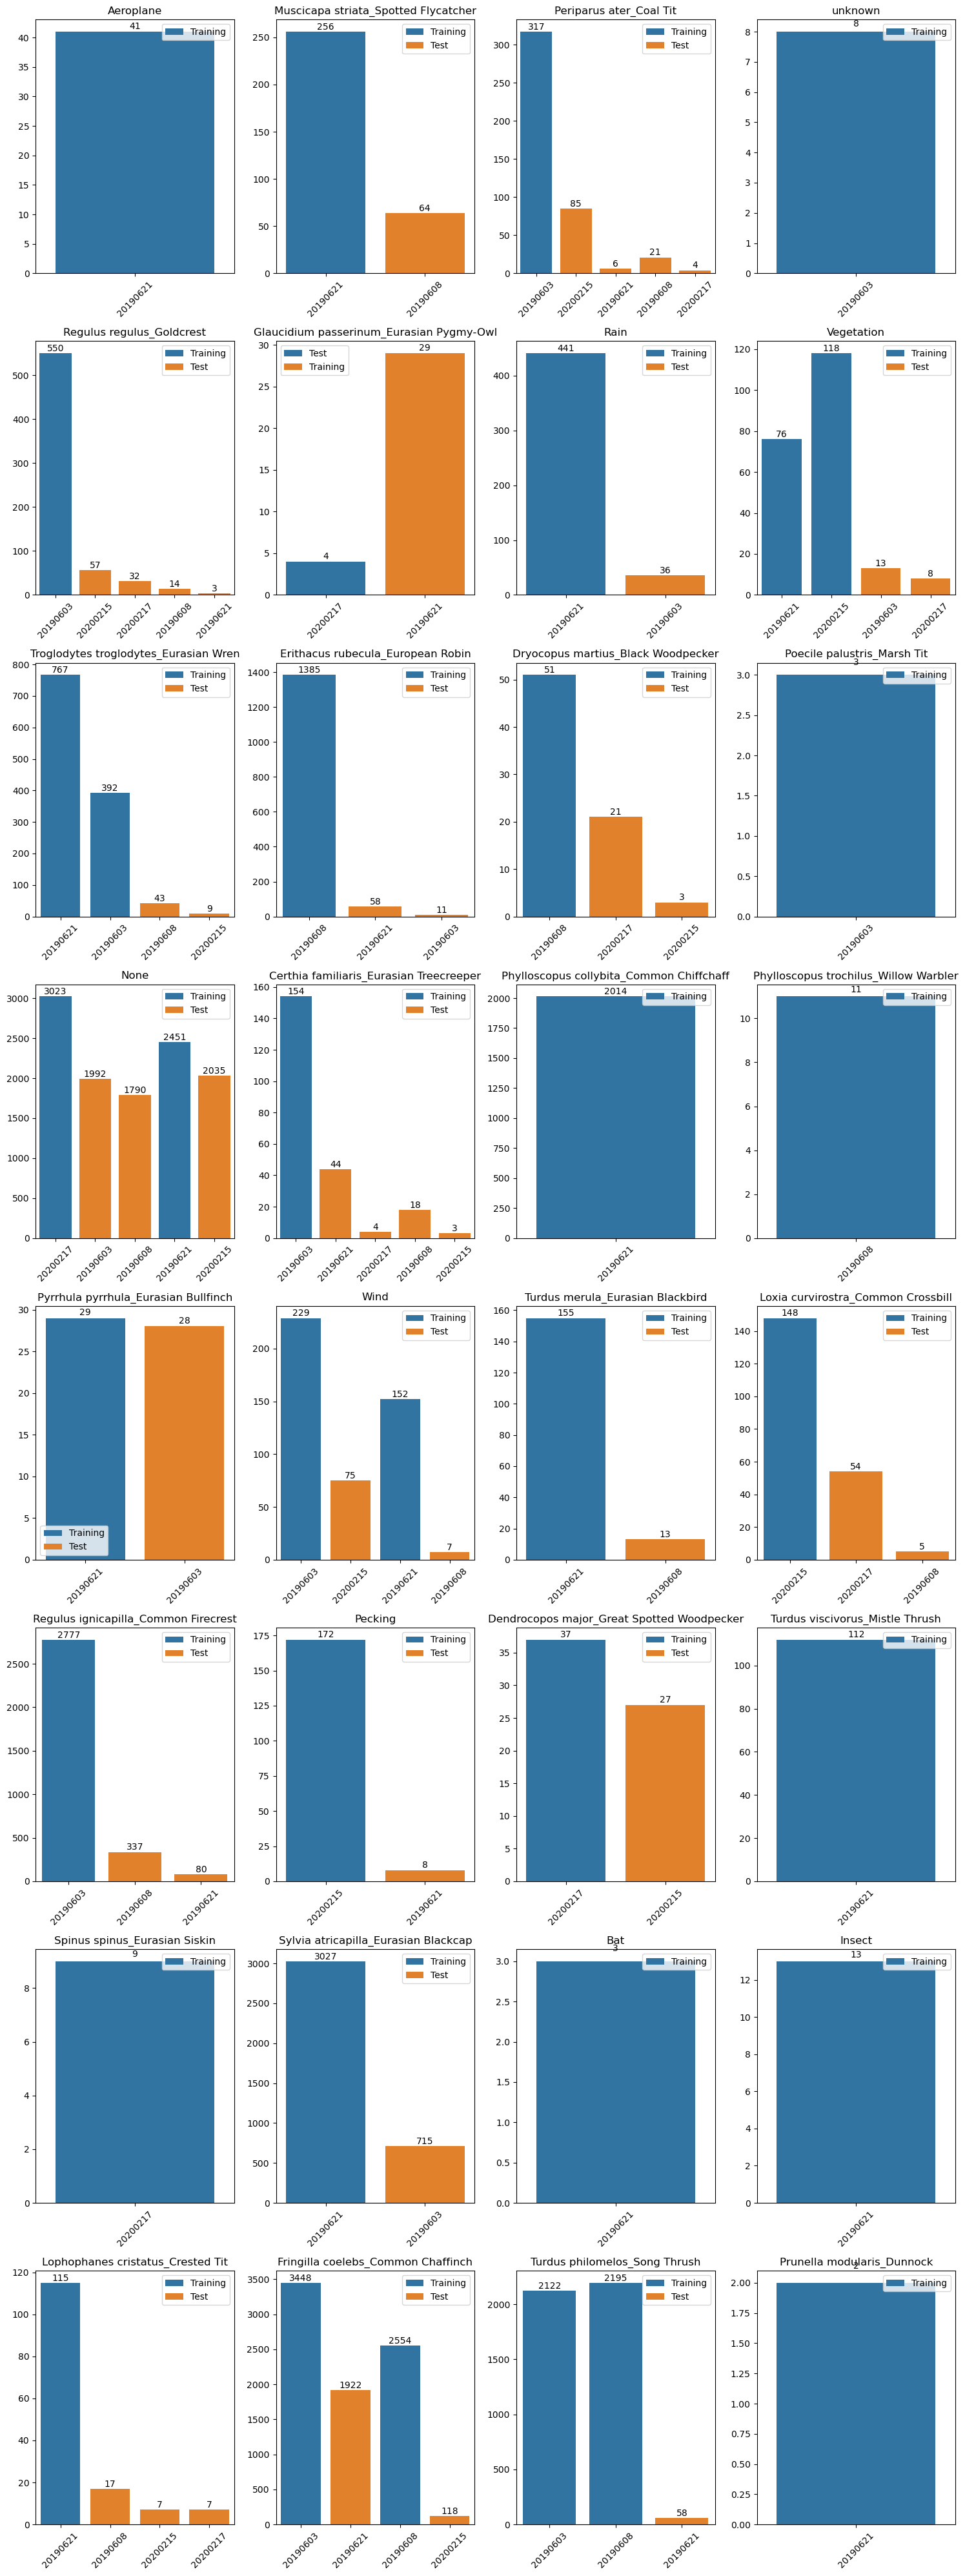

In [ ]:

# Supponiamo che 'species_date_count' contenga i tuoi dati
n_species = len(train_test_division.keys())

cols = 4
rows = (n_species // cols) + (n_species % cols != 0) 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, species in enumerate(train_test_division.keys()):
    dates = list(train_test_division[species].keys())
    counts = [value["count"] for value in train_test_division[species].values()]
    if len(dates) > 1:
        is_training = ["Training" if value["is_training"] else "Test" for value in train_test_division[species].values()]
    else:
        is_training = ["Training"]
    sns.barplot(x=dates, y=counts, ax=axes[i], hue=is_training)

    for j, count in enumerate(counts):
        axes[i].text(j, count + 0.1, str(count), ha='center', va='bottom')
    axes[i].set_title(species)
    axes[i].tick_params(axis='x', rotation=45)  # Ruota le etichette sull'asse x se necessario

for i in range(n_species, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # Aggiusta lo spazio tra i grafici
plt.show()


# Test set creation
Here we move the segments from the source (all the segments divided by species) to the test set, as the species_date_count describes 

In [17]:
train_folder = f"{DATASET_PATH}/train"
test_folder = f"{DATASET_PATH}/test"
valid_folder = f"{DATASET_PATH}/valid"
os.makedirs(test_folder, exist_ok=True)
for species in os.listdir(train_folder):
    if len(train_test_division[species]) <= 1:
        continue    # leave it there
    os.makedirs(os.path.join(test_folder, species), exist_ok=True)
    for audio in os.listdir(os.path.join(train_folder, species)):
        test_dates = [date for date in train_test_division[species].keys() 
                      if train_test_division[species][date]["is_training"] == False]
        audio_date = audio.split("_")[0]
        if audio_date in test_dates:
            source = os.path.join(train_folder, species, audio)
            dest = os.path.join(test_folder, species, audio)
            os.rename(source, dest)

In [ ]:
# # MOVE EVERYTHING BACK TO TRAINING
# train_folder = f"E:/Giacomo/Tovanella/{DATASET_NAME}/train"
# test_folder = f"E:/Giacomo/Tovanella/{DATASET_NAME}/test"
# valid_folder = f"E:/Giacomo/Tovanella/{DATASET_NAME}/valid"
# removed = f"E:/Giacomo/Tovanella/{DATASET_NAME}/removed"

# for species in os.listdir(test_folder):
    # for audio in os.listdir(os.path.join(test_folder, species)):
    #     os.rename(
    #         os.path.join(test_folder, species, audio),
    #         os.path.join(train_folder, species, audio),
    #     )
# for species in os.listdir(removed):
#     os.rename(
#         os.path.join(removed, species),
#         os.path.join(train_folder, species),
#     )

# WABAD Integration

In [10]:
train_folder = f"{DATASET_PATH}/train"
test_folder = f"{DATASET_PATH}/test"
WABAD_FOLDER = "/home/giacomoschiavo/WABAD/segments"

dataset_species_count = {}
for species in os.listdir(test_folder):
    dataset_species_count[species] = {
        "train": len(os.listdir(os.path.join(train_folder, species))),
        "test": len(os.listdir(os.path.join(test_folder, species))),
        "wabad": len(os.listdir(os.path.join(WABAD_FOLDER, species))) if os.path.exists(os.path.join(WABAD_FOLDER, species)) else 0
    }

wabad_species = os.listdir(WABAD_FOLDER)
dataset_species_count_df = pd.DataFrame.from_dict(dataset_species_count, orient='index')
dataset_species_count_df.index.name = 'Species'
dataset_species_count_df = dataset_species_count_df.reset_index() # Make 'Species' a regular column

dataset_species_count_df["In WABAD?"] = dataset_species_count_df["Species"].apply(lambda x: x in wabad_species)
dataset_species_count_df.sort_values(by="train", ascending=False)

,Species,train,test,wabad,In WABAD?
8,None,5497,6296,0,False
18,Fringilla coelebs_Common Chaffinch,5326,2035,0,False
19,Turdus philomelos_Song Thrush,4297,58,0,False
16,Sylvia atricapilla_Eurasian Blackcap,3027,713,0,False
13,Regulus ignicapilla_Common Firecrest,2775,403,0,False
6,Erithacus rubecula_European Robin,1378,67,0,False
5,Troglodytes troglodytes_Eurasian Wren,1156,52,0,False
2,Regulus regulus_Goldcrest,541,103,198,True
3,Rain,441,32,0,False
10,Wind,355,82,0,False


In [6]:
import random

# MOVE WABAD TO TRAINING FOLDER
for specie in os.listdir(WABAD_FOLDER):
    # select a maximum of 1000 segments per species
    NUM_SEGMENTS = 1000
    all_audios = os.listdir(os.path.join(WABAD_FOLDER, specie))
    if len(all_audios) < NUM_SEGMENTS:
        selected_audios = all_audios
    else:
        # Estrai 1000 file audio a caso
        selected_audios = random.sample(all_audios, NUM_SEGMENTS)
    for audio in selected_audios:
        os.rename(
            os.path.join(WABAD_FOLDER, specie, audio),
            os.path.join(train_folder, specie, audio)
        )

In [7]:
dataset_species_count_wabad = {}
for species in os.listdir(test_folder):
    dataset_species_count_wabad[species] = {
        "train": len(os.listdir(os.path.join(train_folder, species))),
        "test": len(os.listdir(os.path.join(test_folder, species)))
    }
dataset_species_count_df = pd.DataFrame.from_dict(dataset_species_count_wabad, orient='index')
dataset_species_count_df.index.name = 'Species'
dataset_species_count_df.sort_values(by="train", ascending=False)


,train,test
Species,,
Fringilla coelebs_Common Chaffinch,6002,2040
Turdus philomelos_Song Thrush,4317,58
Sylvia atricapilla_Eurasian Blackcap,3027,715
Regulus ignicapilla_Common Firecrest,2777,417
Regulus regulus_Goldcrest,1550,106
Erithacus rubecula_European Robin,1385,69
Periparus ater_Coal Tit,1317,116
Troglodytes troglodytes_Eurasian Wren,1159,52
Turdus merula_Eurasian Blackbird,1155,13


# Validation set creation
We can move some data into the validation set, if there's enough 

In [30]:
# take 10% of the training set and give it to the validation data
valid_folder = f"{DATASET_PATH}/valid"
train_folder = f"{DATASET_PATH}/train"
for species in os.listdir(train_folder):
    if len(species.split("_")) <= 1:
        continue
    valid_species_folder = os.path.join(valid_folder, species)
    os.makedirs(valid_species_folder, exist_ok=True)
    if len(os.listdir(valid_species_folder)) > 0:
        continue
    all_audios = os.listdir(os.path.join(train_folder, species))
    n_samples = len(all_audios) // 10
    audio_samples = np.random.choice(all_audios, n_samples, replace=False)
    for audio in audio_samples:
        os.rename(
            os.path.join(train_folder, species, audio),
            os.path.join(valid_species_folder, audio)
        )

In [17]:
def print_dataset_count_table(dataset_path):
    train_folder = f"{dataset_path}/train"
    valid_folder = f"{dataset_path}/valid"
    test_folder = f"{dataset_path}/test"

    dataset_count = {}
    for species in os.listdir(test_folder):
        dataset_count[species] = {
            "train": len(os.listdir(os.path.join(train_folder, species))),
            # "valid": len(os.listdir(os.path.join(valid_folder, species))),
            "test": len(os.listdir(os.path.join(test_folder, species)))
        }
    dataset_species_count_df = pd.DataFrame.from_dict(dataset_count, orient='index')
    dataset_species_count_df.index.name = 'Species'
    return dataset_species_count_df.sort_values(by="train", ascending=False)


In [23]:
DATASET_PATH = '/home/giacomoschiavo/segments/DATASET_CNN'
print_dataset_count_table(DATASET_PATH)

,train,test
Species,,
Fringilla coelebs_Common Chaffinch,6002,2040
None,5474,5817
Turdus philomelos_Song Thrush,4317,58
Sylvia atricapilla_Eurasian Blackcap,3027,715
Regulus ignicapilla_Common Firecrest,2777,417
Regulus regulus_Goldcrest,1550,106
Erithacus rubecula_European Robin,1385,69
Periparus ater_Coal Tit,1317,116
Troglodytes troglodytes_Eurasian Wren,1159,52


In [22]:
DATASET_PATH = '/home/giacomoschiavo/segments/DATASET_CNN_small'
print_dataset_count_table(DATASET_PATH)

,train,test
Species,,
None,5497,6296
Fringilla coelebs_Common Chaffinch,5326,2035
Turdus philomelos_Song Thrush,4297,58
Sylvia atricapilla_Eurasian Blackcap,3027,713
Regulus ignicapilla_Common Firecrest,2775,403
Erithacus rubecula_European Robin,1378,67
Troglodytes troglodytes_Eurasian Wren,1156,52
Regulus regulus_Goldcrest,541,103
Rain,441,32


# Augmentation

In [12]:
import librosa
import soundfile as sf
from audiomentations import Compose, PitchShift, TimeStretch, AddBackgroundNoise, Gain

In [13]:
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

def save_audio(file_path, audio, sr):
    sf.write(file_path, audio, sr)

In [25]:
bg_noise_path = f"{DATASET_PATH}/train/None"
bg_noises = os.listdir(bg_noise_path)
augmentations = {
    "psA": Compose([PitchShift(min_semitones=-5, max_semitones=-5, p=1.0)]),
    "psB": Compose([PitchShift(min_semitones=5, max_semitones=5, p=1.0)]),
    "ts": Compose([TimeStretch(min_rate=0.8, max_rate=1.2, p=1.0)]),
    "bn": Compose([
        AddBackgroundNoise(sounds_path=os.path.join(bg_noise_path, random.choice(bg_noises)), p=1.0),
        Gain(min_gain_db=-10, max_gain_db=10, p=0.75)  # Cambia il volume del rumore
    ]),
}

def apply_augmentations(file_path, output_dir):
    audio, sr = load_audio(file_path)
    
    for aug_name, aug in augmentations.items():
        file_name = os.path.splitext(file_path)[0].split('/')[-1]
        if "aug" in file_name:
            continue
        save_audio_path = f"{output_dir}/{file_name}_aug_{aug_name}.wav"
        if os.path.exists(save_audio_path):
            continue
        augmented_audio = aug(samples=audio, sample_rate=sr)
        save_audio(save_audio_path, augmented_audio, sr)

In [15]:
# pick samples where validation samples == 0
train_folder = f'{DATASET_PATH}/train'
species_to_augment = []
threshold = 500
for species in os.listdir(train_folder):
    if len(species.split("_")) <= 1:
        continue
    if len(os.listdir(os.path.join(train_folder, species))) >= threshold:
        continue
    species_to_augment.append(species)

species_to_augment

['Muscicapa striata_Spotted Flycatcher',
 'Periparus ater_Coal Tit',
 'Glaucidium passerinum_Eurasian Pygmy-Owl',
 'Dryocopus martius_Black Woodpecker',
 'Poecile palustris_Marsh Tit',
 'Certhia familiaris_Eurasian Treecreeper',
 'Phylloscopus trochilus_Willow Warbler',
 'Pyrrhula pyrrhula_Eurasian Bullfinch',
 'Turdus merula_Eurasian Blackbird',
 'Loxia curvirostra_Common Crossbill',
 'Dendrocopos major_Great Spotted Woodpecker',
 'Turdus viscivorus_Mistle Thrush',
 'Spinus spinus_Eurasian Siskin',
 'Lophophanes cristatus_Crested Tit',
 'Prunella modularis_Dunnock']

In [ ]:
for species in species_to_augment:
    files = os.listdir(os.path.join(train_folder, species))
    print("Augmenting ", species)
    for i in tqdm(range(len(files)), colour="blue"):
        audio = files[i]
        apply_augmentations(os.path.join(train_folder, species, audio), os.path.join(train_folder, species))

In [27]:
print_dataset_count_table(DATASET_PATH)

,train,test
Species,,
None,5497,6296
Fringilla coelebs_Common Chaffinch,5326,2035
Turdus philomelos_Song Thrush,4297,58
Sylvia atricapilla_Eurasian Blackcap,3027,713
Regulus ignicapilla_Common Firecrest,2775,403
Periparus ater_Coal Tit,1405,105
Erithacus rubecula_European Robin,1378,67
Muscicapa striata_Spotted Flycatcher,1280,59
Troglodytes troglodytes_Eurasian Wren,1156,52


## Augmentation removal

In [4]:
# extracted from above
augmented_species = ['Certhia familiaris_Eurasian Treecreeper',
 'Dryocopus martius_Black Woodpecker',
 'Glaucidium passerinum_Eurasian Pygmy-Owl',
 'Lophophanes cristatus_Crested Tit',
 'Loxia curvirostra_Common Crossbill',
 'Muscicapa striata_Spotted Flycatcher',
 'Poecile palustris_Marsh Tit',
 'Prunella modularis_Dunnock',
 'Pyrrhula pyrrhula_Eurasian Bullfinch']


In [8]:
train_path = f"{DATASET_PATH}/train"
target_path = f"{DATASET_PATH}/removed_aug"
os.makedirs(target_path, exist_ok=True)
for species in os.listdir(train_path):
    if species not in augmented_species:
        continue
    for audio in os.listdir(os.path.join(train_path, species)):
        os.makedirs(os.path.join(target_path, species), exist_ok=True)
        if "aug" in audio:
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(target_path, species, audio),
            )

In [10]:
print_dataset_count_table()

,train,valid,test
Species,,,
Turdus merula_Eurasian Blackbird,7626,847,13
Fringilla coelebs_Common Chaffinch,5402,600,2040
Turdus philomelos_Song Thrush,3886,431,58
Periparus ater_Coal Tit,3614,401,116
Sylvia atricapilla_Eurasian Blackcap,2725,302,715
Regulus ignicapilla_Common Firecrest,2500,277,417
Regulus regulus_Goldcrest,1574,174,106
Erithacus rubecula_European Robin,1247,138,69
Troglodytes troglodytes_Eurasian Wren,1044,115,52


# SNR Filter

In [3]:
def calculate_snr(audio_path):
    """
    Calculates the Signal-to-Noise Ratio (SNR) of an audio file with respect to a noise segment.

    - audio_path: path to the audio file
    - noise_start, noise_end: time interval in seconds where the noise is isolated
    """
    
    noise_audio = f"{DATASET_PATH}/None/20190603_110000_322_5.wav"
    y_noise, sr_noise = librosa.load(noise_audio, sr=None)
    
    noise_sample = y_noise[:]
    
    y, sr = librosa.load(audio_path, sr=None)
    signal_power = np.mean(y**2)
    noise_power = np.mean(noise_sample**2)
    
    if noise_power == 0:
        return np.inf
    
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

In [6]:
species_to_reduce = []
threshold = 200
train_folder = f'{DATASET_PATH}/train'
for species in os.listdir(train_folder):
    if len(species.split("_")) <= 1:
        continue
    if len(os.listdir(os.path.join(train_folder, species))) <= threshold:
        continue
    species_to_reduce.append(species)

In [8]:
info = {}
for species in species_to_reduce:
    info[species] = {}
    for audio_path in os.listdir(os.path.join(train_folder, species)):
        full_audio_path = os.path.join(train_folder, species, audio_path)
        snr = calculate_snr(full_audio_path)
        info[species][audio_path] = snr

In [9]:
with open(f"utils/{DATASET_NAME}/audio_snr_info.json", "w") as f:
    json.dump(info, f)

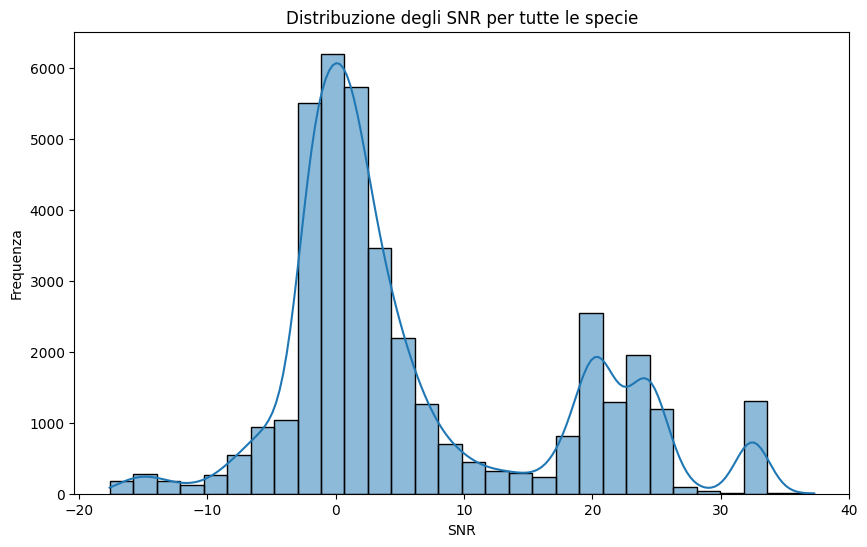

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Raccolta di tutti gli SNR in una lista unica
all_snr_values = []
for specie in info:
    all_snr_values.extend(info[specie].values())

# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
sns.histplot(all_snr_values, bins=30, kde=True)

# Titoli e labels
plt.title("Distribuzione degli SNR per tutte le specie")
plt.xlabel("SNR")
plt.ylabel("Frequenza")

# Mostra il grafico
plt.show()


In [15]:
# Initialize the dictionary to store the results
top_800_per_specie = {}

# Iterate through each species in the 'info' dictionary
for species, files in info.items():
    # Filter files with SNR less than 20 dB
    snr_below_20 = {file: snr for file, snr in files.items() if snr < 20}
    
    # Sort the filtered files by SNR in descending order
    sorted_files = sorted(snr_below_20.items(), key=lambda item: item[1], reverse=True)
    
    # Select the first 800 files from the sorted list
    best_800 = [file for file, snr in sorted_files[:800]]
    
    # Add the species and the list of the best 800 files to the results dictionary
    top_800_per_specie[species] = best_800

# The 'top_800_per_specie' dictionary now contains species as keys
# and lists of the best 800 audio files with SNR less than 20 dB as values

In [22]:
target_path = f"{DATASET_PATH}/snr_removed"
train_path = f"{DATASET_PATH}/train"
os.makedirs(target_path, exist_ok=True)
for species in os.listdir(train_path):
    if species not in species_to_reduce:
        continue
    for audio in os.listdir(os.path.join(train_path, species)):
        os.makedirs(os.path.join(target_path, species), exist_ok=True)
        if audio not in top_800_per_specie[species]:
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(target_path, species, audio)
            )


In [22]:
print_dataset_count_table()

,train,valid,test
Species,,,
Fringilla coelebs_Common Chaffinch,5402,600,2040
Turdus philomelos_Song Thrush,3886,431,58
Sylvia atricapilla_Eurasian Blackcap,2725,302,715
Regulus ignicapilla_Common Firecrest,2500,277,417
Erithacus rubecula_European Robin,1247,138,69
Troglodytes troglodytes_Eurasian Wren,1044,115,52
Regulus regulus_Goldcrest,495,55,106
Periparus ater_Coal Tit,286,31,116
Muscicapa striata_Spotted Flycatcher,231,25,64


### Undo SNR removal

In [4]:
import os
snr_folder_path = f"{DATASET_PATH}/snr_removed"
train_path = f"{DATASET_PATH}/train"
for species in os.listdir(snr_folder_path):
    for audio in os.listdir(os.path.join(snr_folder_path, species)):
        os.rename(
            os.path.join(snr_folder_path, species, audio),
            os.path.join(train_path, species, audio)
        )


### Undo WABAD from Train and Valid

In [ ]:
train_path = f"{DATASET_PATH}/train"
# valid_path = f"{DATASET_PATH}/valid"
wabad_segments = "E:/Giacomo/Tovanella/wabad_segments"

for species in os.listdir(train_path):
    for audio in os.listdir(os.path.join(train_path, species)):
        is_wabad = len(audio.split("_")[0]) != 8
        if is_wabad:
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(wabad_segments, species, audio)
            )

### Undo Validation

In [18]:
train_path = f"{DATASET_PATH}/train"
valid_path = f"{DATASET_PATH}/valid"

for species in os.listdir(valid_path):
    for audio in os.listdir(os.path.join(valid_path, species)):
        os.rename(
            os.path.join(valid_path, species, audio),
            os.path.join(train_path, species, audio)
        )